In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def get_differential_filter():
    # To do
    #filter_x = np.tile(np.array([1,0,-1]),(3,1))
    #filter_y = np.tile(np.vstack(np.array([1,0,-1])),3)
    #gaussian = np.array([[0,1,0],[1,2,1],[0,1,0]]) # Add the gaussian filter to mimic Park?
    #using self-defined solbelman filter instead.
    filter_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    filter_x = filter_y.T
    
    print(filter_x)
    print(filter_y)
    
    return filter_x, filter_y


def filter_image(im, filter):
    # To do
    im_zero_pad = np.pad(im, ((1,1),(1,1)), 'constant')
    height,width = im.shape
    im_filtered = np.zeros(im.shape)
    
    for i in range(height):
        for j in range(width):
            cell = im_zero_pad[i:i+3,j:j+3]
            im_filtered[i,j] = np.sum(cell*filter)
    
    plt.imshow(im_filtered ,cmap='gray')
    plt.show()
    
    return im_filtered


def get_gradient(im_dx, im_dy):
    # To do
    grad_mag = np.sqrt(im_dx**2+im_dy**2)
    
    grad_angle = np.zeros(im_dx.shape)
        
    for i in range(im_dx.shape[0]):
        for j in range(im_dy.shape[1]):
            grad_angle[i,j] = np.arctan2(im_dy[i,j],im_dx[i,j])
            
    plt.imshow((grad_angle+np.pi) % np.pi ,cmap='jet')
    plt.show()
    
    plt.imshow(grad_mag ,cmap='gray')
    plt.show()
    
    print(np.max(grad_mag))
        
    return grad_mag, grad_angle #将 angle 值域缩到0-180


def build_histogram(grad_mag, grad_angle, cell_size = 8):
    # To do
    angle_im = np.degrees(grad_angle)%180 #归一至180度
    
    print(angle_im)
    print(np.max(angle_im))
    
    oder_im = np.zeros(angle_im.shape)
    
    oder_im[np.where(np.logical_and(angle_im>=15, angle_im<45))] = 1
    
    oder_im[np.where(np.logical_and(angle_im>=45, angle_im<75))] = 2
    
    oder_im[np.where(np.logical_and(angle_im>=75, angle_im<105))] = 3
    
    oder_im[np.where(np.logical_and(angle_im>=105, angle_im<135))] = 4
    
    oder_im[np.where(np.logical_and(angle_im>=135, angle_im<165))] = 5
    
    oder_im[np.where(angle_im>=165)] = 0
    
    oder_im[np.where(angle_im<15)] = 0
    
    
         # 分为六类 
    
    ori_histo = np.zeros((oder_im.shape[0]//cell_size,oder_im.shape[1]//cell_size,6))
    
    for i in range(oder_im.shape[0]):
        for j in range(oder_im.shape[1]):
            #print(i//cell_size,j//cell_size,oder_im[i,j])
            oder_x = i//cell_size
            oder_y = j//cell_size
            bin_num = np.int(oder_im[i,j])
            ori_histo[oder_x,oder_y, bin_num] =grad_mag[i,j] + ori_histo[oder_x,oder_y,bin_num]
    
    
    
    print(oder_im)
    print(np.load('order.npy'))
    
    print(np.sum(np.sum(np.load('order.npy')-oder_im)))
    
    print(np.where((np.load('order.npy')-oder_im)**2>0))
    #print(ori_histo[:,:,0])
    return ori_histo,oder_im,grad_angle,angle_im


def get_block_descriptor(ori_histo, block_size = 2):
    # To do
    eps = 0.001
    len_x = ori_histo.shape[0]-block_size+1
    len_y = ori_histo.shape[1]-block_size+1
    ori_histo_normalized = np.zeros((len_x,len_y,6,block_size,block_size))
    
    for i in range(len_x):
        for j in range(len_y):
            
            H_sum = np.sqrt(np.sum(ori_histo[i:i+block_size,j:j+block_size,:]**2)+eps**2) #find sum of hi
            ori_histo_normalized [i,j,:,:,:] = (ori_histo[i:i+block_size,j:j+block_size,:]/H_sum).reshape((6,2,2))
            #for m in range(ori_histo.shape[2]):
                 #print(ori_histo[i,j,m])
                 #H_sum = np.sqrt(np.power(ori_histo[i,j,m],2.0)+np.power(ori_histo[i,j+1,m],2.)+np.power(ori_histo[i+1,j,m],2.) +np.power(ori_histo[i+1,j+1,m],2.) + np.power(eps,2))\n",
                 #ori_histo_normalized[i,j,m,0,0] = ori_histo[i,j,m]/H_sum \n",
                 #ori_histo_normalized[i,j,m,0,1] = ori_histo[i,j+1,m]/H_sum   \n",
                 #ori_histo_normalized[i,j,m,1,0] = ori_histo[i+1,j,m]/H_sum   \n",
                 #ori_histo_normalized[i,j,m,1,1] = ori_histo[i+1,j+1,m]/H_sum   \n",
                
          
                #ori_histo_normalized[i,j,m,:,:] =ori_histo[i:i+block_size,j:j+block_size,m]/H_sum #do the divide
                
    ori_histo_normalized = ori_histo_normalized.reshape((len_x,len_y,6*block_size**2)) #reshape the matrix

    return ori_histo_normalized


def extract_hog(im):
    # convert grey-scale image to double format
    im = im.astype('float') / 255.0
    
    # normalized the pic
    im = im/np.max(im)
    
    # To do
    block_size = 2
    
    cell_size = 8
    
    dx,dy = get_differential_filter()
    
    im_dx = filter_image(im, dx)
    
    im_dy = filter_image(im, dy)
    
    grad_mag, grad_angle = get_gradient(im_dx, im_dy)
    
    ori_histo = build_histogram(grad_mag, grad_angle, cell_size)
    
    ori_histo_normalized =  get_block_descriptor(ori_histo, block_size)
    
    hog = ori_histo_normalized

    # visualize to verify
    visualize_hog(im, hog, cell_size, block_size)

    return hog


# visualize histogram of each block
def visualize_hog(im, hog, cell_size, block_size):
    num_bins = 6
    max_len = 7 # control sum of segment lengths for visualized histogram bin of each block
    im_h, im_w = im.shape
    num_cell_h, num_cell_w = int(im_h / cell_size), int(im_w / cell_size)
    num_blocks_h, num_blocks_w = num_cell_h - block_size + 1, num_cell_w - block_size + 1
    histo_normalized = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
    histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len # num_blocks_h x num_blocks_w x num_bins
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[int(cell_size*block_size/2): cell_size*num_cell_w-(cell_size*block_size/2)+1: cell_size], np.r_[int(cell_size*block_size/2): cell_size*num_cell_h-(cell_size*block_size/2)+1: cell_size])
    mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins)) # expand to same dims as histo_normalized
    mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins)) # expand to same dims as histo_normalized
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
        color='white', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    
    
    plt.xlim(200,250)
    plt.ylim(200,250)
    plt.show()

In [11]:
# visualize histogram of each cell
def visualize_hog_cell(im, ori_histo, cell_size):
    norm_constant = 1e-3
    num_cell_h, num_cell_w, num_bins = ori_histo.shape
    max_len = cell_size / 3
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size/2: cell_size*num_cell_w: cell_size], np.r_[cell_size/2: cell_size*num_cell_h: cell_size])
    bin_ave = np.sqrt(np.sum(ori_histo ** 2, axis=2) + norm_constant ** 2) # (ori_histo.shape[0], ori_histo.shape[1])
    histo_normalized = ori_histo / np.expand_dims(bin_ave, axis=2) * max_len # same dims as ori_histo
    mesh_u = histo_normalized * np.sin(angles).reshape((1, 1, num_bins)) # expand to same dims as histo_normalized
    mesh_v = histo_normalized * -np.cos(angles).reshape((1, 1, num_bins)) # expand to same dims as histo_normalized
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - mesh_u[:, :, i], mesh_y - mesh_v[:, :, i], 2 * mesh_u[:, :, i], 2 * mesh_v[:, :, i],
        color='white', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    plt.xlim(200,250)
    plt.ylim(200,250)
    plt.show()


[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


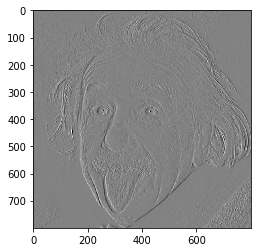

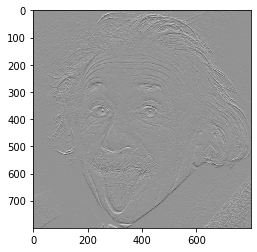

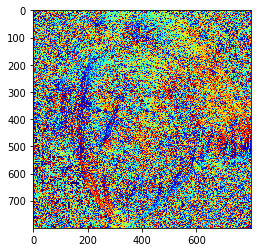

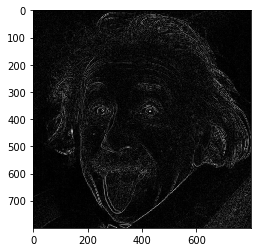

3.4291713070942778
[[ 46.06091169  90.26162275  92.67542666 ...  83.65980825  78.69006753
  131.268603  ]
 [  5.19442891  96.84277341 123.11134196 ...  57.52880771  30.37912601
  175.23635831]
 [  2.98663699 104.03624347 135.         ...  66.80140949  30.96375653
  178.64680805]
 ...
 [179.55585557 156.80140949  49.39870535 ...  86.18592517 176.18592517
    2.84213788]
 [179.85118013 150.9453959   29.475889   ... 116.56505118  18.43494882
    2.64880576]
 [135.60309119  90.60309119  86.65140519 ...  88.39773865  86.53792694
   44.72585961]]
180.0
[[2. 3. 3. ... 3. 3. 4.]
 [0. 3. 4. ... 2. 1. 0.]
 [0. 3. 4. ... 2. 1. 0.]
 ...
 [0. 5. 2. ... 3. 0. 0.]
 [0. 5. 1. ... 4. 1. 0.]
 [5. 3. 3. ... 3. 3. 1.]]
[[2. 3. 3. ... 3. 3. 4.]
 [0. 3. 4. ... 2. 1. 0.]
 [0. 3. 4. ... 2. 1. 0.]
 ...
 [0. 5. 2. ... 3. 0. 0.]
 [0. 5. 1. ... 4. 1. 0.]
 [5. 3. 3. ... 3. 3. 1.]]
0.0
(array([], dtype=int64), array([], dtype=int64))
(99, 99, 24)
(100, 100, 6)


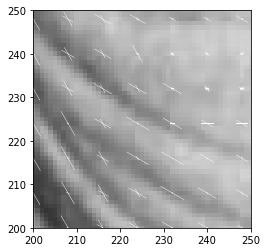

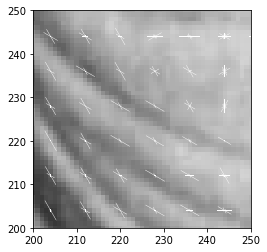

In [12]:
im = cv2.imread('e2.png', 0)

# convert grey-scale image to double format
im = im.astype('float') / 255.0
    
    # normalized the pic
im = im/np.max(im)
    
    # To do
block_size = 2
    
cell_size = 8
    
dx,dy = get_differential_filter()
    
im_dx = filter_image(im, dx)
    
im_dy = filter_image(im, dy)
    
grad_mag, grad_angle = get_gradient(im_dx, im_dy)


    
ori_histo , oder_im,grad_angle,angle_im = build_histogram(grad_mag, grad_angle, cell_size)
    
ori_histo_normalized =  get_block_descriptor(ori_histo, block_size)
    
hog = ori_histo_normalized



print(hog.shape)

print(ori_histo.shape)

    # visualize to verify
visualize_hog(im, hog, cell_size, block_size)


visualize_hog_cell(im, ori_histo, cell_size)

In [74]:
a = np.load('order.npy')
b =oder_im

print(a[2,349],b[2,349],grad_angle[2,349],angle_im[2,349])

1.0 2.0 0.7853981633974483 45.0


In [88]:
p = np.array([[[2,1],[3,3]],[[2,3],[6,7]]])
p[1][1]

array([6, 7])